In [1]:
!pip install diffusers transformers -qq

In [2]:
!pip install torch

In [1]:
import torch
from PIL import Image
from tqdm.notebook import tqdm
from diffusers import StableDiffusionPipeline

In [2]:
all_components = StableDiffusionPipeline.from_pretrained("22h/vintedois-diffusion-v0-1")
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

safety_checker/model.safetensors not found
Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [3]:
torch_device

'cuda'

In [4]:
vae = all_components.vae.to(torch_device)
unet = all_components.unet.to(torch_device)
text_encoder = all_components.text_encoder.to(torch_device)
scheduler = all_components.scheduler
tokenizer = all_components.tokenizer

/tmp/ipykernel_238/787360687.py:28: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


0it [00:00, ?it/s]

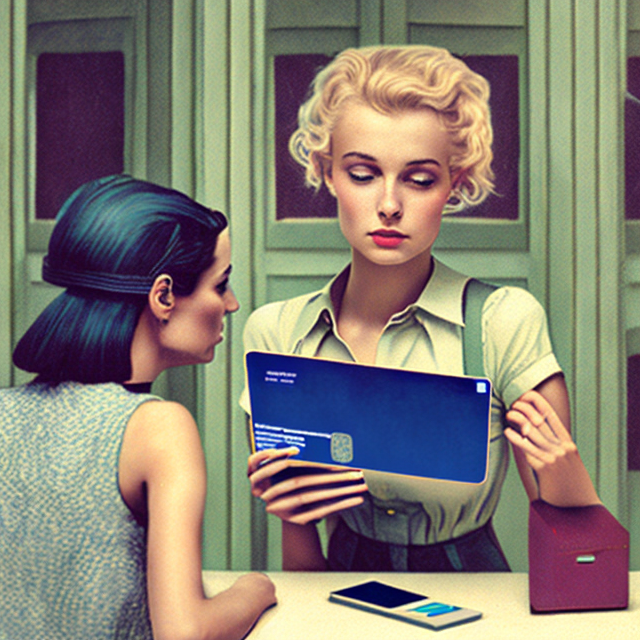

In [8]:
# Some settings
prompt = ["estilovintedois photo of a young woman looking to a credit card bank"]
height = 640                        # Altura da imagem a ser gerada
width = 640                         # Largura da imagem a ser gerada
num_inference_steps = 30            # Número de iterações para remoção de ruído
guidance_scale = 7.5                # Liberdade/Força do condicionamento
generator = torch.manual_seed(44)   # Seed para gerar o vetor ruidoso inicial
batch_size = 1

# Preparacao do texto: Enviamos um texto de condicionamento e tambem deixamos uma parte para livre geração
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0] 
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Configurando o scheduler para pegar os coeficientes a serem utilizados
scheduler.set_timesteps(num_inference_steps)

# Gerando primeiro latente ruidoso no formato de entrada da UNet
latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator, dtype=text_embeddings.dtype
)
latents = latents.to(torch_device)
latents = latents * scheduler.init_noise_sigma # Scaling

# Loop
for i, t in tqdm(enumerate(list(scheduler.timesteps))):
    latent_model_input = torch.cat([latents] * 2) # Pois geramos dois inputs
    latent_model_input = scheduler.scale_model_input(latent_model_input, t)

    # Predicao do ruido
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # Aplica guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # Gerando o novo vetor
    latents = scheduler.step(noise_pred, t, latents).prev_sample

# Escala magica descrita no paper
latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(latents).sample

# Exibicao da imagem
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]